In [1]:
import gym, rec_gym
from rec_gym import env_1_args
import numpy as np

In [2]:
env_1_args['user_drift_sigma'] = 0
env_1_args['noise_sigma'] = 0
env_1_args['user_drift_autoreg_coef'] = 1
env_1_args

{'K': 4,
 'num_items': 100,
 'num_users': 20,
 'embedding_dimension': 2,
 'cluster_var': 16,
 'in_cluster_var': 0.5,
 'active_user_change_proba': 0.1,
 'noise_sigma': 0,
 'user_init_sigma': 5,
 'user_drift_autoreg_coef': 1,
 'user_drift_sigma': 0,
 'user_type': 'drifting',
 'seed': 42,
 'action_is_items': True}

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import tensorflow as tf

tf.reset_default_graph()
sess = tf.InteractiveSession()

/home/anton/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
from agents.utils import ReplayBuffer

In [6]:
printt = None

In [7]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, InputLayer, Activation, activations, Input, concatenate


def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

class Qagent(object):
    def __init__(self, sess, state_dim, action_dim, epsilon=0.4, action_size=4, logdir='./logs/'):
        self._state_dim = state_dim
        self._action_dim = action_dim
        self._action_size = action_size
        
        self._logdir = logdir
        
        self._sess = sess
        
        self.epsilon = epsilon
        self.gamma = 0.9
        self.lr = 1e-4
        self.optimizer = tf.train.RMSPropOptimizer(self.lr)
        
        self.state, self.action, self.agent, self.weights = self._create_network('agent')
        
        self.qvalues = self.agent(tf.concat([self.state, self.action], axis=-1))
        
        self.target_state, self.target_action, self.target, self.target_weights = self._create_network('target')
        self.target_qvalues = self.target(tf.concat([self.target_state, self.target_action], axis=-1))
        
        self.train_op, self.td_loss = self._create_train_op()
        self.target_update_op = self._create_target_update_op()
        
        self.merged = tf.summary.merge_all()
        self.train_writer = tf.summary.FileWriter(self._logdir,
                                                  self._sess.graph)
        self.summary = None
           
        
    def _create_network(self, name):
        
        with tf.variable_scope(name_or_scope=name):
            state_ph = tf.placeholder('float32', 
                                      shape=(None,) + self._state_dim, 
                                      name='state')
            action_ph = tf.placeholder('float32', 
                                       shape=(None,) + self._action_dim, 
                                       name='action')

            net = Sequential(
                layers = [
                    InputLayer(input_shape=(self._state_dim[0] + self._action_dim[0], )),
                    Dense(200, activation='relu'),
                    Dense(100, activation='relu'),
                    Dense(1)
                ]
            )
            weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)
        
            return state_ph, action_ph, net, weights
        
    def _create_train_op(self):

        with tf.variable_scope(name_or_scope='train') as train_scope:
        
            # s a r s' A 
            self.s_ph = tf.placeholder(tf.float32, shape=(None,) + self._state_dim)
            self.a_ph = tf.placeholder(tf.float32, shape=(None, self._action_size) + self._action_dim)
            self.r_ph = tf.placeholder(tf.float32, shape=[None])
            self.done_ph = tf.placeholder(tf.float32, shape=[None])
            self.next_s_ph = tf.placeholder(tf.float32, shape=(None,) + self._state_dim)
            # pool of actions at time T (ot T+1?)
            self.next_as_ph =  tf.placeholder(tf.float32, 
                                              shape=(None, None,) + self._action_dim)
            
            
            repeat_current_state = tf.expand_dims(self.s_ph, 1)
            repeat_current_state = tf.tile(repeat_current_state, multiples=[1, self._action_size, 1])            
            current_qvalue = self.agent(tf.concat([repeat_current_state, self.a_ph], axis=-1))
            
            current_qvalue = tf.squeeze(current_qvalue)
            current_qvalue = tf.reduce_sum(current_qvalue, axis=-1)
            
                           
            repeat_states = tf.expand_dims(self.next_s_ph, 1)
            repeat_states = tf.tile(repeat_states, multiples=[1, tf.shape(self.next_as_ph)[1], 1])
            
            next_qvalues = self.target(tf.concat([repeat_states,
                                                  self.next_as_ph], axis=-1))
            next_qvalues = tf.squeeze(next_qvalues, axis=-1)
            
            k_max_next_qvalues, _ = tf.nn.top_k(next_qvalues, k=self._action_size)
            # should sum but not over batches
            next_max_qvalue = tf.reduce_sum(k_max_next_qvalues, axis=-1)
                        
            reference = self.r_ph + self.gamma * next_max_qvalue
            
            td_loss = (current_qvalue - reference) ** 2
            td_loss = tf.reduce_mean(td_loss)
            
            global printt
            if printt is None:
#                 ()
#                 (?,)
#                 (?, 1, 1)
                print(next_max_qvalue.shape)
                print(reference.shape)
                print(current_qvalue.shape)
                printt=2
            
            tf.summary.histogram('next_max_qvalue', next_max_qvalue)
            tf.summary.histogram('topk', k_max_next_qvalues)
            tf.summary.histogram('target', reference)
            tf.summary.histogram('qvalue', current_qvalue)
            
            tf.summary.scalar('td_loss', td_loss)
            # Op to calculate every variable gradient
            grads = tf.gradients(td_loss, self.weights)
            grads = list(zip(grads, self.weights))
            # Summarize all gradients
            for grad, var in grads:
                print(var.name)
                tf.summary.histogram(var.name + '/gradient', grad)
            
            
        return self.optimizer.minimize(td_loss, var_list=self.weights), td_loss
    
    def _create_target_update_op(self):
        """ assign target_network.weights variables to their respective agent.weights values. """
        assigns = []
        for w_agent, w_target in zip(self.weights, self.target_weights):
            assigns.append(tf.assign(w_target, w_agent, validate_shape=True))
        return assigns
        
        
    
    def rank_action(self, state, actions):
        
        qvalues = self._sess.run(self.qvalues, {self.state : np.repeat(state.reshape(-1, self._state_dim[0]), 
                                                                     actions.shape[0], axis=0), 
                                                 self.action : actions})
        return qvalues
    
    # add rank_actions target
    # action for environement is an array of items 
    # action for q function is an item 
    def target_rank_action(self, state, actions):
        return self._sess.run(self.target_qvalues, {
            self.target_state : np.repeat(state.reshape(-1, self._state_dim[0]), 
                                          actions.shape[0], axis=0),
            self.target_action : actions,
        })
        
        
    def sample_action(self, state, actions):
        
        qvalues = self.rank_action(state, actions).reshape(-1)
        
        if np.random.rand() > self.epsilon:
            idxs = qvalues.argsort()[::-1][:self._action_size]
        else:
            idxs = np.random.choice(range(actions.shape[0]), size=self._action_size, 
                                     p=softmax(qvalues))
            
        return actions[idxs]
        
        
    def train(self, batch):
        s, a, r, next_s, actions, done = batch
        
#         print(s.shape)
#         print(a.shape)
#         print(r.shape)
#         print(next_s.shape)
#         print(actions.shape)      
#         print(self.next_as_ph.shape)
        
        _, loss, self.summary = self._sess.run([self.train_op, self.td_loss, self.merged], {
                                    self.s_ph : s,
                                    self.a_ph : a,
                                    self.r_ph : r,
                                    self.done_ph : done,
                                    self.next_s_ph : next_s,
                                    self.next_as_ph : actions
                                })
        return loss
        
    
    def update_target_weights(self):
        self._sess.run(self.target_update_op)
        
    def write_summary(self, step): 
        if self.summary:
            self.train_writer.add_summary(self.summary, global_step=step)

Using TensorFlow backend.


In [8]:
def make_env():
    env = gym.make('prim-gym-v1')
    env.init_gym(env_1_args)
    return env

In [9]:
def play_and_record(agent, env, exp_replay, n_steps=1, greedy=False):
    # initial state
    s = env.reset()
    
    rewards = []
    # Play the game for n_steps as per instructions above
    for _ in range(n_steps):
        
        (user, items) = s
        
        actions = items
        action = agent.sample_action(user, actions)
        
        next_s, r, done, _ = env.step(action)
            
        rewards.append(r)
        
        (next_user, next_items) = next_s
        
        exp_replay.add(user, action, r, 
                       next_user, next_items, done)
         
        if done:
            s = env.reset()
        else:
            s = next_s

    return np.mean(rewards)


def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    
    for _ in range(n_games):
        (user, items) = env.reset()
        
        s = user
        actions = items
        
        reward = 0
        for _ in range(t_max):
            
            action = agent.sample_action(s, actions)
            
            obs, r, done, _ = env.step(action)
            
            (next_user, next_items) = obs
            
            s = next_user
            actions = next_items
            
            reward += r
            if done: break
                
        rewards.append(reward)
    return np.mean(rewards)

In [10]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
from pandas import DataFrame
moving_average = lambda x, span=100, **kw: DataFrame({'x':np.asarray(x)}).x.ewm(span=span, **kw).mean().values
%matplotlib inline

In [11]:
mean_rw_history = []
td_loss_history = []

env = make_env()

state_dim = tuple([env_1_args['embedding_dimension']])
action_dim = tuple([env_1_args['embedding_dimension']])

# n_actions = env_1_args['num_items']

agent = Qagent(sess, state_dim, action_dim, epsilon=0.5, action_size=5, logdir='./logs/run_diff_ctr')

sess.run(tf.global_variables_initializer())
agent.update_target_weights()

exp_replay = ReplayBuffer(10**3)
play_and_record(agent, env, exp_replay, n_steps=500)

(100, 2)
(?,)
(?,)
<unknown>
agent/dense_1/kernel:0
INFO:tensorflow:Summary name agent/dense_1/kernel:0/gradient is illegal; using agent/dense_1/kernel_0/gradient instead.
agent/dense_1/bias:0
INFO:tensorflow:Summary name agent/dense_1/bias:0/gradient is illegal; using agent/dense_1/bias_0/gradient instead.
agent/dense_2/kernel:0
INFO:tensorflow:Summary name agent/dense_2/kernel:0/gradient is illegal; using agent/dense_2/kernel_0/gradient instead.
agent/dense_2/bias:0
INFO:tensorflow:Summary name agent/dense_2/bias:0/gradient is illegal; using agent/dense_2/bias_0/gradient instead.
agent/dense_3/kernel:0
INFO:tensorflow:Summary name agent/dense_3/kernel:0/gradient is illegal; using agent/dense_3/kernel_0/gradient instead.
agent/dense_3/bias:0
INFO:tensorflow:Summary name agent/dense_3/bias:0/gradient is illegal; using agent/dense_3/bias_0/gradient instead.


0.082

buffer size = 1000, epsilon = 0.09334


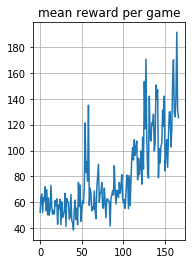

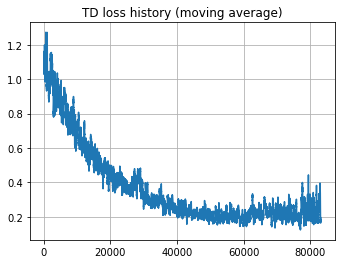

  8%|▊         | 83152/1000000 [41:09<7:33:48, 33.67it/s]

KeyboardInterrupt: 

  8%|▊         | 83152/1000000 [41:20<7:35:46, 33.53it/s]

In [12]:
batch_size = 64

for i in trange(10**6):
    
    # play
    play_and_record(agent, env, exp_replay, 10)
    
    # train
    batch = exp_replay.sample(batch_size)
    loss_t = agent.train(batch) 
    td_loss_history.append(loss_t)
    
    # adjust agent parameters
    if i % 500 == 0:
        #load_weigths_into_target_network(agent, target_network)
        #calling 'load_weights_into_target_network' repeatedly cause creating tf copy operator
        #again and again, which bloat memory consumption along training step
        #create'copy_step' once 
        if i % 2000 == 0:
            agent.update_target_weights() 
        
        agent.write_summary(step=i)
        # TODO : epsilon scheduler in agent as function
        agent.epsilon = max(agent.epsilon * 0.99, 0.01)
        
        mean_rw_history.append(evaluate(env, agent, n_games=3, t_max=1000))
    
    if i % 100 == 0:
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))
        
        plt.subplot(1,2,1)
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(loss_t)
        plt.figure(figsize=[12, 4])
        plt.subplot(1,2,2)
        plt.title("TD loss history (moving average)")
        plt.plot(moving_average(np.array(td_loss_history), span=100, min_periods=100))
        plt.grid()
        plt.show()

In [21]:
import gym.wrappers
env_monitor = gym.wrappers.Monitor(env,directory="./videos/run_diff_ctr/",force=True)
evaluate(env_monitor, agent, n_games=1, t_max=1000) 
env_monitor.close()

In [22]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/run_diff_ctr/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/run_gauss_kernel_ctr/"+video_names[-1]))